# Dense Forecasting

A dense layer is just a regular layer of neurons in a neural network. Each neuron recieves input from all the neurons in the previous layer, thus densely connected. The layer has a weight matrix W, a bias vector b, and the activations of previous layer a. The following is te docstring of class Dense from the keras documentation:

output = activation(dot(input, kernel) + bias)where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer.

## Setup

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [25]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def window_dataset(series, window_size, batch_size=128,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 20-step windows for training. Every 20 steps is 1 trading month since the markets are only open Monday - Friday.

In [31]:
# Read in data
spy = pd.read_csv('../SPY.csv')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'], utc=True).dt.normalize()
c = spy.Date
# Save target series
series = spy['Close']

# Create train data set
train_split_date = '2014-12-31T00:00:00.000Z'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02T00:00:00.000Z'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

5521 5522 6527 6528 7918


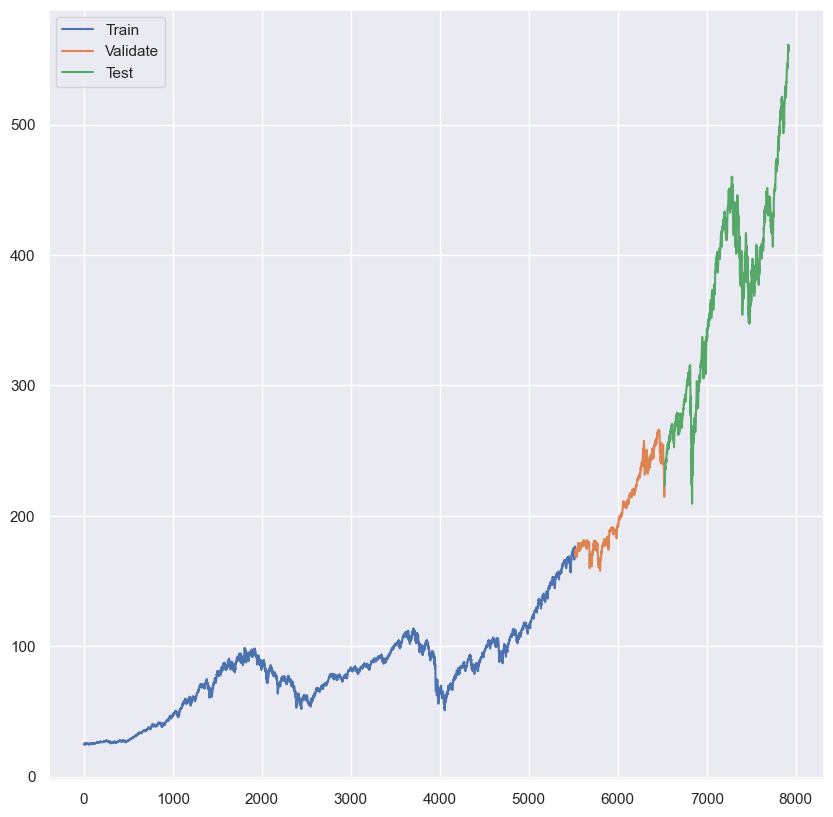

In [32]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [34]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

### Dense Model Forecasting

#### Find Learning Rate

In [35]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = window_dataset(normalized_x_train.flatten(), window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.Nadam(lr=1e-7)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


c:\Users\ahath\AppData\Local\r-miniconda\lib\site-packages\keras\optimizers\optimizer_v2\nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


43/43 [==============================] - 2s 10ms/step - loss: 0.0671 - mae: 0.3157 - lr: 1.0000e-07
Epoch 2/100
43/43 [==============================] - 0s 6ms/step - loss: 0.0671 - mae: 0.3157 - lr: 1.1220e-07
Epoch 3/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0671 - mae: 0.3156 - lr: 1.2589e-07
Epoch 4/100
43/43 [==============================] - 0s 6ms/step - loss: 0.0671 - mae: 0.3156 - lr: 1.4125e-07
Epoch 5/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0671 - mae: 0.3155 - lr: 1.5849e-07
Epoch 6/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0670 - mae: 0.3154 - lr: 1.7783e-07
Epoch 7/100
43/43 [==============================] - 0s 6ms/step - loss: 0.0670 - mae: 0.3154 - lr: 1.9953e-07
Epoch 8/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0670 - mae: 0.3153 - lr: 2.2387e-07
Epoch 9/100
43/43 [==============================] - 0s 6ms/step - loss: 0.0669 - mae: 0.3152 - lr: 2.5119e-07
Epoch 10/100

(1e-07, 1.0, 0.0, 0.1)

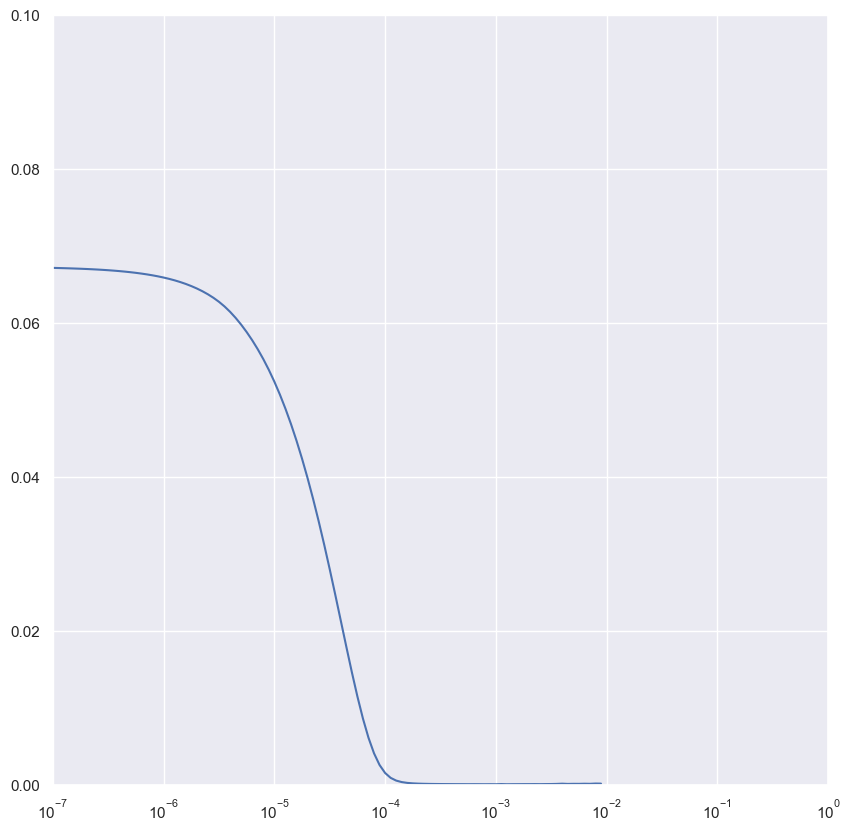

In [36]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1, 0, .1])

#### Create Model

In [37]:
# Clear back end
keras.backend.clear_session()

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Set Window Size
window_size = 30
train_set = window_dataset(normalized_x_train.flatten(), window_size)
valid_set = window_dataset(normalized_x_valid.flatten(), window_size)

# Build 2 layer model with 10 neurons each and 1 output layer
model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

# Set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-2)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Set early Stopping
early_stopping = keras.callbacks.EarlyStopping(patience=20)

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Fit model
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


c:\Users\ahath\AppData\Local\r-miniconda\lib\site-packages\keras\optimizers\optimizer_v2\nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


     38/Unknown - 1s 7ms/step - loss: 0.0038 - mae: 0.0570INFO:tensorflow:Assets written to: my_checkpoint\assets
43/43 [==============================] - 3s 44ms/step - loss: 0.0034 - mae: 0.0533 - val_loss: 5.5844e-04 - val_mae: 0.0241
Epoch 2/500
43/43 [==============================] - 0s 9ms/step - loss: 1.7451e-04 - mae: 0.0140 - val_loss: 9.7907e-04 - val_mae: 0.0383
Epoch 3/500
43/43 [==============================] - 0s 9ms/step - loss: 0.0012 - mae: 0.0255 - val_loss: 0.0178 - val_mae: 0.1837
Epoch 4/500
43/43 [==============================] - 1s 11ms/step - loss: 2.2232e-04 - mae: 0.0160 - val_loss: 0.0025 - val_mae: 0.0612
Epoch 5/500
43/43 [==============================] - 1s 10ms/step - loss: 0.0012 - mae: 0.0256 - val_loss: 0.0194 - val_mae: 0.1924
Epoch 6/500
43/43 [==============================] - 1s 30ms/step - loss: 2.0156e-04 - mae: 0.0152 - val_loss: 5.0130e-04 - val_mae: 0.0229
Epoch 7/500
43/43 [==============================] - 0s 9ms/step - loss: 1.3650e-04 

In [38]:
model = keras.models.load_model("my_checkpoint")

In [39]:
dense_forecast = model_forecast(model, spy_normalized_to_traindata.flatten()[x_test.index.min() - window_size:-1], window_size)[:, 0]

44/44 [==============================] - 0s 3ms/step


In [40]:
spy_normalized_to_traindata.flatten().shape

(7919,)

In [41]:
# Undo the scaling
dense_forecast = x_train_scaler.inverse_transform(dense_forecast.reshape(-1,1)).flatten()
dense_forecast.shape

(1391,)

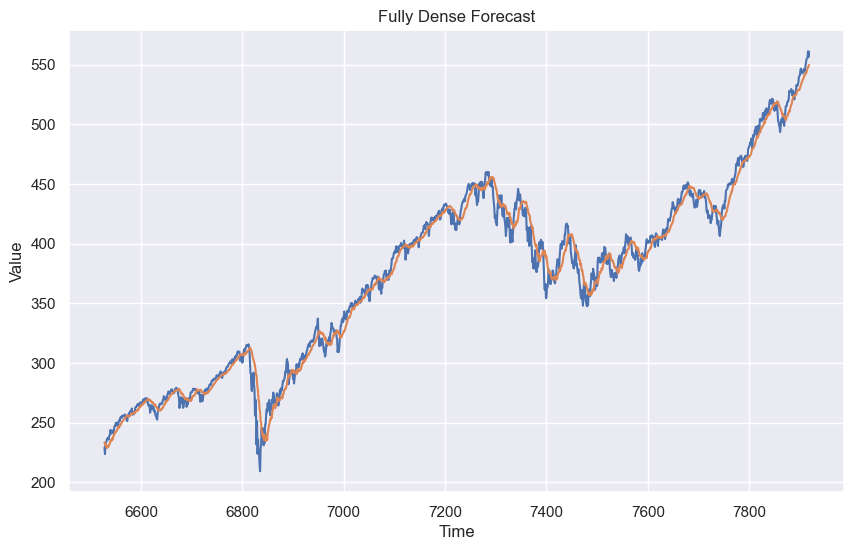

In [42]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

plt.figure(figsize=(10, 6))
plt.title('Fully Dense Forecast')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plot_series(x_test.index, x_test)
plot_series(x_test.index, dense_forecast)

#### Dense Model Result

In [43]:
keras.metrics.mean_absolute_error(x_test, dense_forecast).numpy()

7.4027243